In [6]:
# Author: Dimitris Spathis <sdimitris@csd.auth.gr>

import numpy as np
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml  # Updated to fetch_openml
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn import decomposition
from sklearn.model_selection import cross_val_score  # Updated import
import time  # computation time benchmark
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA  # Updated import
from sklearn import neighbors
from sklearn.neighbors import NearestCentroid  # Updated import
from sklearn.decomposition import KernelPCA
from sklearn.utils import shuffle

# Fetching the MNIST dataset
mnist = fetch_openml("mnist_784", version=1)

print("------------Data shape (samples, dimensions)--")
print(mnist.data.shape)  # (70000, 784)

print("------------Number of classes-----------------")
print(np.unique(mnist.target))  # array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

X, y = np.float32(mnist.data[:70000]) / 255., np.float32(mnist.target[:70000])
X, y = shuffle(X, y)
# Keeping just 15k training samples due to kPCA memory requirements
X_train, y_train = np.float32(X[:15000]) / 255., np.float32(y[:15000])
X_test, y_test = np.float32(X[60000:]) / 255., np.float32(y[60000:])

# Kernel PCA keeping 300 components
kpca = KernelPCA(kernel="rbf", n_components=300, gamma=1)
X_kpca = kpca.fit_transform(X_train)
X_test = kpca.transform(X_test)

# LDA for dimensionality reduction. It should keep [classes-1] components.
lda = LDA()
X_lda = lda.fit_transform(X_kpca, y_train)
X_test = lda.transform(X_test)

# kNN classification
start = int(round(time.time() * 1000))
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_lda, y_train)

print("---------(5) Cross validation accuracy--------")
print(cross_val_score(clf, X_lda, y_train, cv=5))  # Updated function call

end = int(round(time.time() * 1000))
print("--NN fitting finished in ", (end - start), "ms--------------")

expected = y_test
predicted = clf.predict(X_test)

print("--------------------Results-------------------")
print("Classification report for kNN classifier %s:\n%s\n" % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

# Nearest Centroid classification
start = int(round(time.time() * 1000))
classifier = NearestCentroid()
classifier.fit(X_lda, y_train)
print("---------(5) Cross validation accuracy--------")
print(cross_val_score(classifier, X_lda, y_train, cv=5))  # Updated function call

end = int(round(time.time() * 1000))
print("--Centroid fitting finished in ", (end - start), "ms--------------")

expected = y_test
predicted = classifier.predict(X_test)

print("--------------------Results-------------------")
print("Classification report for Centroid classifier %s:\n%s\n" % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


------------Data shape (samples, dimensions)--
(70000, 784)
------------Number of classes-----------------
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
---------(5) Cross validation accuracy--------
[0.90333333 0.908      0.90866667 0.915      0.91833333]
--NN fitting finished in  2556 ms--------------
--------------------Results-------------------
Classification report for kNN classifier KNeighborsClassifier():
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95       952
         1.0       0.93      0.97      0.95      1117
         2.0       0.91      0.89      0.90      1017
         3.0       0.89      0.88      0.88      1042
         4.0       0.89      0.92      0.90       916
         5.0       0.86      0.85      0.85       904
         6.0       0.94      0.94      0.94      1023
         7.0       0.92      0.92      0.92      1056
         8.0       0.89      0.81      0.85       985
         9.0       0.88      0.89      0.88   

In [7]:
from sklearn.preprocessing import StandardScaler

# Select two digits to analyze
digits = [3, 7]

# Filter the dataset for the selected digits
X_filtered = X[np.isin(y, digits)]
y_filtered = y[np.isin(y, digits)]

results = {}

for digit in digits:
    # Data for the current digit
    X_digit = X_filtered[y_filtered == digit]

    # Standardize the data
    scaler = StandardScaler().fit(X_digit)
    X_std = scaler.transform(X_digit)

    # 1. Average digit
    average_digit = np.mean(X_digit, axis=0)

    # 2. Covariance matrix
    covariance_matrix = np.cov(X_std.T)

    # 3. PCA for the first eight components
    pca = PCA(n_components=8)
    pca.fit(X_std)
    principal_components = pca.components_

    # Digit reconstructions for various L
    reconstructions = {}
    reconstruction_errors = {}
    for L in [1, 8, 16, 64, 256]:
        pca_L = PCA(n_components=L)
        X_reduced = pca_L.fit_transform(X_std)
        X_reconstructed = pca_L.inverse_transform(X_reduced)
        reconstructions[L] = scaler.inverse_transform(X_reconstructed)  # Convert back to original scale
        reconstruction_errors[L] = np.mean(np.square(X_digit - reconstructions[L]))

    results[digit] = {
        'average_digit': average_digit,
        'covariance_matrix': covariance_matrix,
        'principal_components': principal_components,
        'reconstructions': reconstructions,
        'reconstruction_errors': reconstruction_errors
    }

# Example code to plot the results for digit 3
digit = 3
average_digit = results[digit]['average_digit']
principal_components = results[digit]['principal_components']
reconstructions = results[digit]['reconstructions']
reconstruction_errors = results[digit]['reconstruction_errors']

# Plotting code here (similar to the previous examples provided)


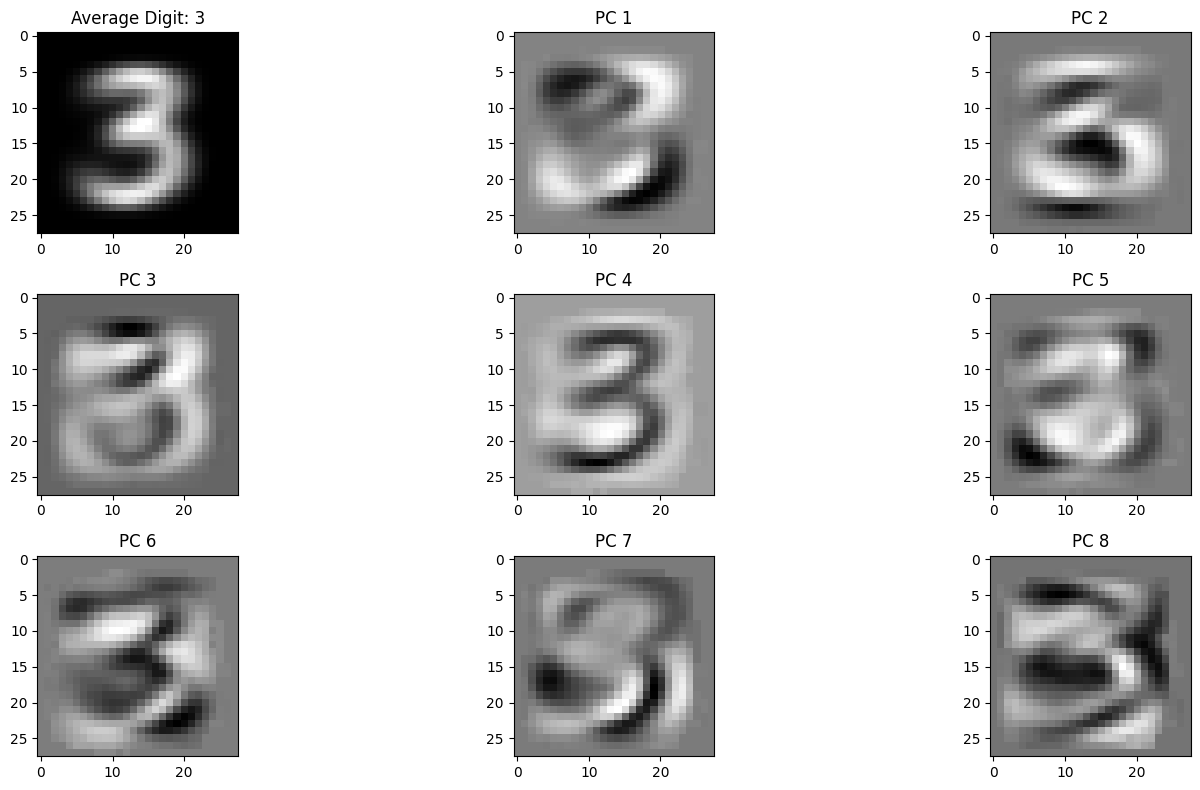

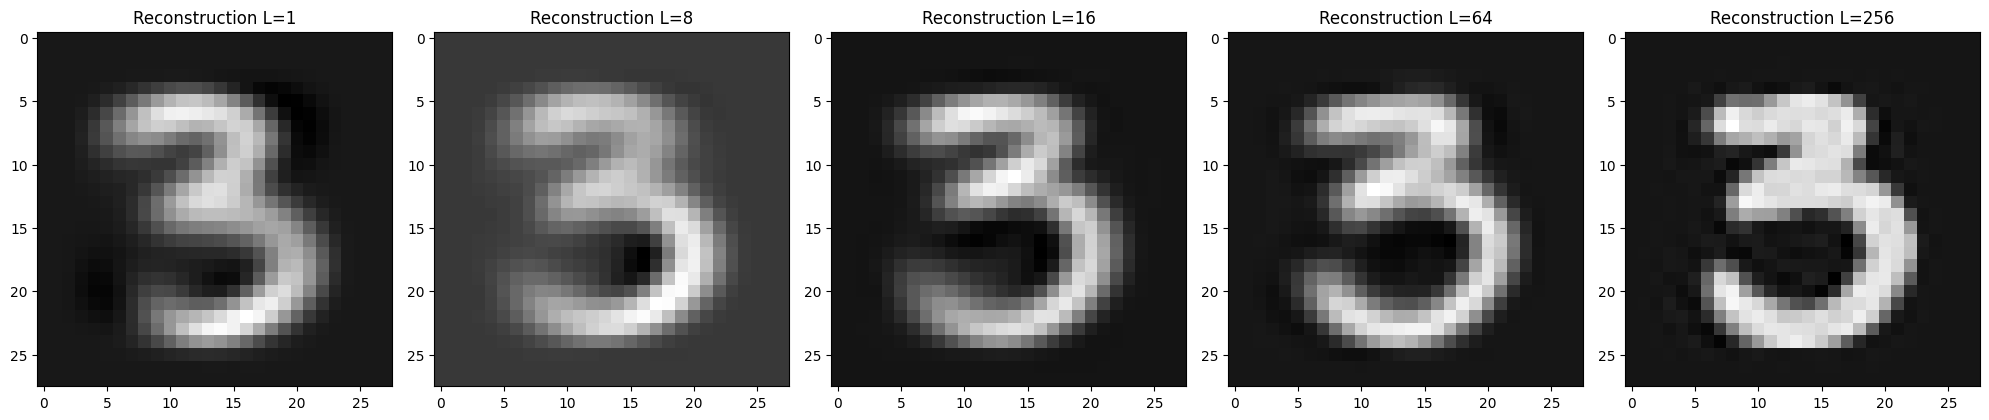

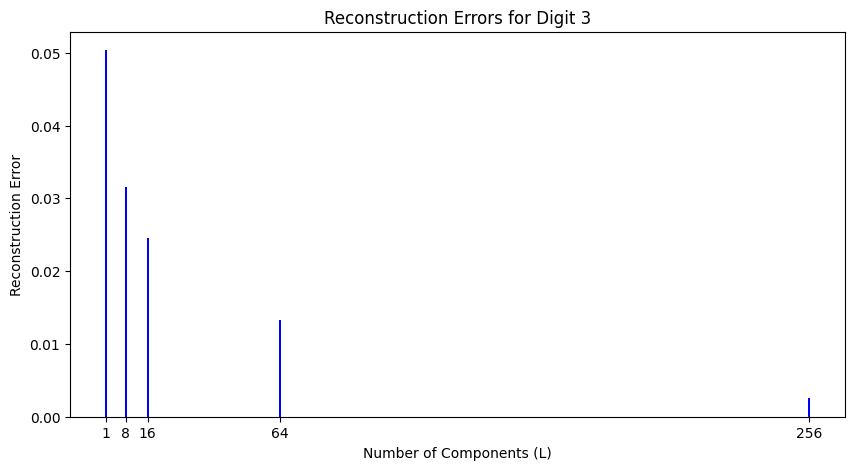

In [9]:
# Function to plot the average digit and principal components
# Adjusted function to plot the average digit and principal components
def plot_digits_and_components(digit, results):
    fig, axs = plt.subplots(3, 3, figsize=(16, 8))  # Adjusted to a 3x3 grid
    average_digit = results[digit]['average_digit']
    principal_components = results[digit]['principal_components']

    # Plot average digit in the first slot
    axs[0, 0].imshow(average_digit.reshape(28, 28), cmap='gray')
    axs[0, 0].set_title(f'Average Digit: {digit}')

    # Adjust loop to populate the rest of the grid with principal components
    for i, component in enumerate(principal_components):
        row = (i + 1) // 3
        col = (i + 1) % 3
        axs[row, col].imshow(component.reshape(28, 28), cmap='gray')
        axs[row, col].set_title(f'PC {i+1}')

    # Hide any unused subplots
    for ax in axs.flat[len(principal_components) + 1:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


# Function to plot digit reconstructions
def plot_digit_reconstructions(digit, reconstructions):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    L_values = [1, 8, 16, 64, 256]

    for i, L in enumerate(L_values):
        reconstructed_digit = reconstructions[L][0]  # Using the first reconstruction for demonstration
        axs[i].imshow(reconstructed_digit.reshape(28, 28), cmap='gray')
        axs[i].set_title(f'Reconstruction L={L}')

    plt.tight_layout()
    plt.show()

# Function to plot reconstruction errors
def plot_reconstruction_errors(digit, reconstruction_errors):
    plt.figure(figsize=(10, 5))
    L_values = list(reconstruction_errors.keys())
    errors = list(reconstruction_errors.values())

    plt.bar(L_values, errors, color='blue')
    plt.xlabel('Number of Components (L)')
    plt.ylabel('Reconstruction Error')
    plt.title(f'Reconstruction Errors for Digit {digit}')
    plt.xticks(L_values)
    plt.show()

# Example usage for digit 3
digit = 3
plot_digits_and_components(digit, results)
plot_digit_reconstructions(digit, results[digit]['reconstructions'])
plot_reconstruction_errors(digit, results[digit]['reconstruction_errors'])

# You can repeat the plotting for other digits by changing the `digit` variable


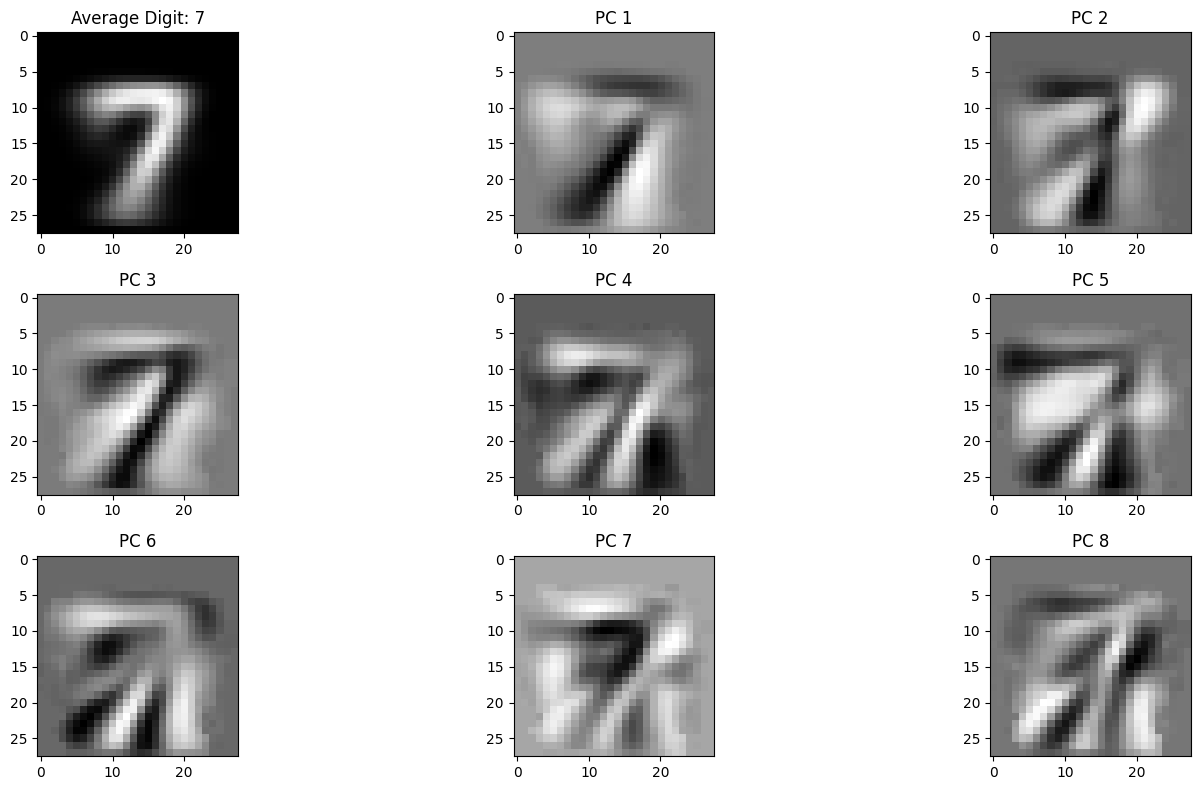

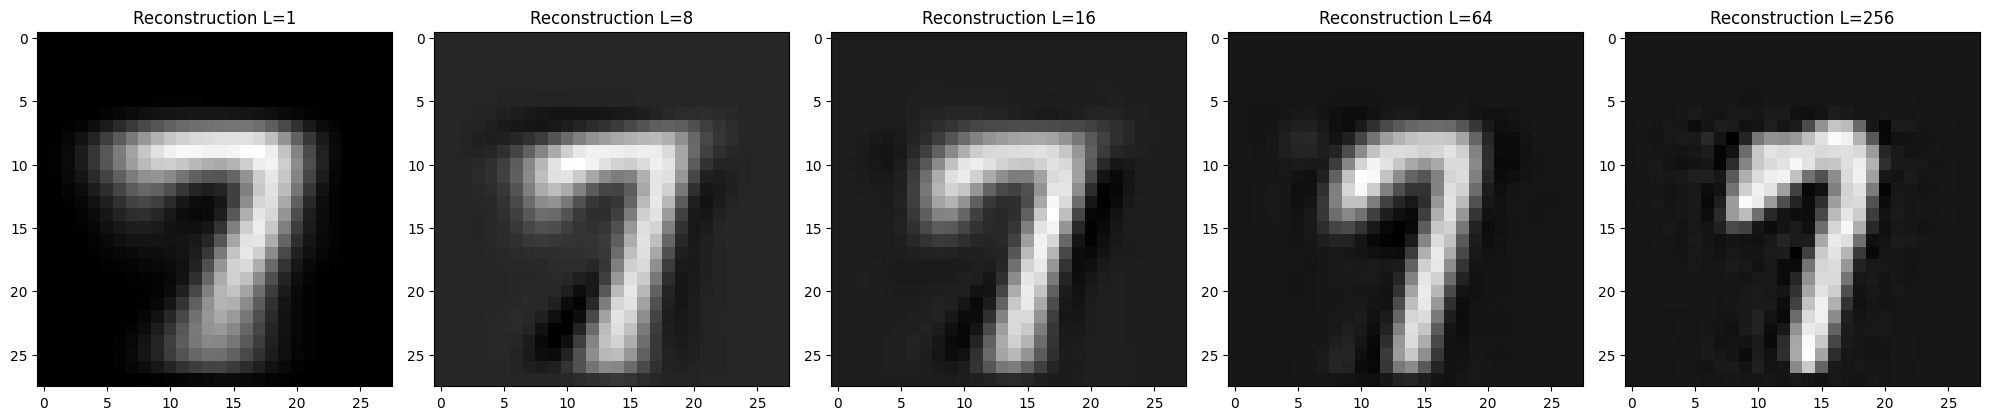

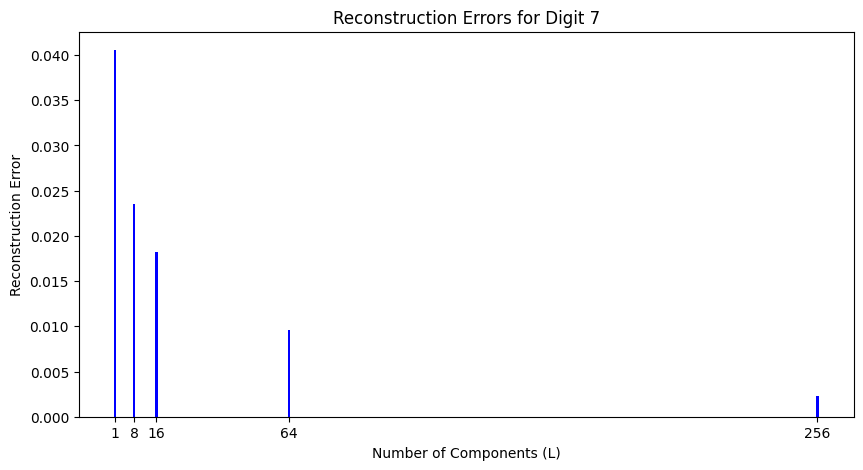

In [10]:
# Example usage for digit 7
digit = 7
plot_digits_and_components(digit, results)
plot_digit_reconstructions(digit, results[digit]['reconstructions'])
plot_reconstruction_errors(digit, results[digit]['reconstruction_errors'])

# You can repeat the plotting for other digits by changing the `digit` variable